# Introduction

Sunspots are regions on the sun's surface that are cooler than the surrounding areas and so appear darker. Sunspots have been observed continuously since 1609, and the first observation dates back a 100 years in china, If sunspots are active, more solar flares will result creating an increase in geomagnetic storm activity for Earth. Therefore during sunspot maximums, the Earth will see an increase in the Northern and Southern Lights and a possible disruption in radio transmissions and power grids.


In [1]:
from IPython.display import YouTubeVideo 
YouTubeVideo('rx9m6H6GeLs', width=1000, height=400) # Relevant till 3:00

# Imports

In [2]:
# %load_ext autoreload
# %autoreload 2
# Data Wrangling & stats
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Helper Handles
from helperhandler import dataHolder
from helperhandler import get_ts_strength, adf_test, kpss_test
from helperhandler import ro_framework, residual_diagnostic

# Models & Stats
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from fbprophet import Prophet
from statsmodels.nonparametric.smoothers_lowess import lowess


Importing plotly failed. Interactive plots will not work.


# Path and Variable Initialisations

In [3]:
root_path = '../'
raw_datapath = root_path+'Raw Data/'
prepared_datapath = root_path+'Prepared Data/'

In [4]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15,7)
plt.style.use('ggplot')

# Load and Explore the Data

In [5]:
dataHolder.load_data()
dataHolder.dataDf.tail()

,Handle,Short Description
11,aus_elecprod,Electricity Production
12,visitor_20r,Visitors to 20 Regions
13,usa_economic,USA Economic Numbers
14,sunspots,Sunspot Numbers
15,retail_sales,Retail Sales


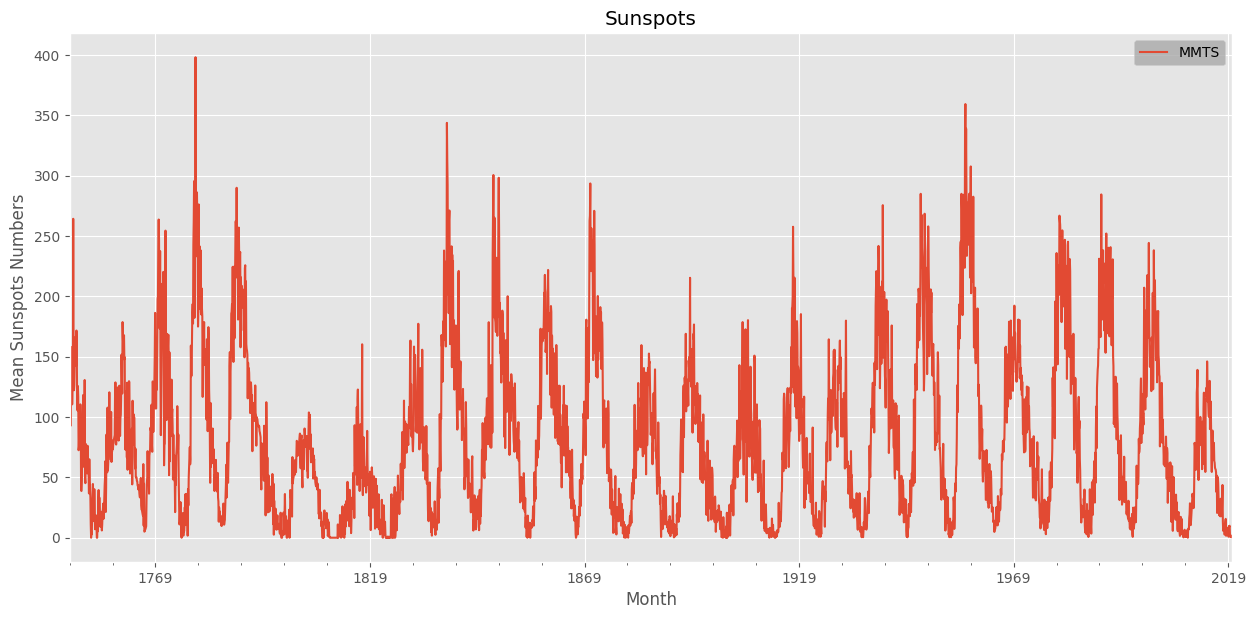

In [6]:
dataobj = dataHolder.bucket['sunspots']
sundata = dataobj.data.copy()
dataHolder.bucket['sunspots'].exploratory_plot()

In [7]:
sundata.index.freq = 'M'
sundata.head()

,MMTS
Month,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


# In-Depth Exploratory Data Analysis & Data Preperation

## Time Series Plot

Try slicing the data and see if you can find the following properties, and quantify them :
- Monthly Seasonality
- Cyclicity

Starting from 12, 24, 36... 11 years=122, 12 years = 144

In [ ]:
sundata = dataobj.data.copy()

In [ ]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='blue')

In [ ]:
sundata.mean()

## NaNs and Zeros in the data

In [ ]:
(sundata==np.nan).sum()

In [ ]:
(sundata==0.0).sum()

<b>There are 67 0.0 in the dataset, which are not supposed to be `Wrong` or `Outliers`  but can be problematic in later stages, how about we try to impute that?</b>

Were we to keep this :-

- We wont be able to use `MAPE` as our metric, which we are going to use
- We wont be able to apply some of the transformations to it

Maybe with the next smallest value in the series??

In [ ]:
sorted(sundata.MMTS.unique())[:10]

In [ ]:
next_min = 0.2
sundata.replace({0.0:next_min}).min()

In [ ]:
sundata=sundata.replace({0.0:next_min})

<b>Lets see how our Time Series looks now</b>

In [ ]:
_=sundata.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(sundata.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='blue')

In [ ]:
sundata.mean()

## Gauging into the cycles

In [ ]:
sundata = sundata[sundata.index>='1901-11-30'].copy()

In [ ]:
sundata['lowess'] = lowess(sundata.MMTS, sundata.reset_index().index, 0.025)[:,1]
sundata.plot()

In [ ]:
sundata.lowess.plot(legend=True)
plt.legend(loc=2)
plt.grid(b=None)
dx = plt.twinx()
sundata['slope'] = np.round(sundata['lowess'].diff(),1).bfill()
sundata['inflected'] = sundata['slope']>0.0
sundata['slope'].plot(ax=dx, color='#869dc2', label='slope')
dx.hlines(3.2, sundata.index.min(),sundata.index.max(), color='red')
dx.hlines(0.0, sundata.index.min(),sundata.index.max(), color='g')
dx.grid(b=None)
_=dx.legend()

In [ ]:
sundata['lowess'].plot()
plt.vlines(sundata[sundata.inflected].index,
           0,350, color='#aabf95')

**Q)** How will you figure out the inflection points?

In [ ]:
sundata.inflected.astype(int)[130:150]
# .diff()

In [ ]:
sundata['cycle_shift'] = sundata.inflected.astype(int).diff(1)==1
sundata['cycle_no'] = sundata.cycle_shift.cumsum()+1
sundata['lowess'].plot()
plt.vlines(sundata[sundata.cycle_shift].index,
           0,350, color='#2e3627')

In [ ]:
# Your solution

In [ ]:
cycle_dates = pd.DataFrame(columns=['Begin', 'End'])
cycle_dates['Begin'] = sundata.reset_index().groupby('cycle_no').Month.first()
cycle_dates['End'] = sundata.reset_index().groupby('cycle_no').Month.last()
cycle_dates['Diff_Months'] = cycle_dates.apply(lambda x : (x.End-x.Begin)/np.timedelta64(1, 'M'), axis=1)
cycle_dates

In [ ]:
cycle_dates.Diff_Months.plot(kind='bar')
plt.hlines(cycle_dates.Diff_Months.mean(),
           -1,
           cycle_dates.index.max(),
           color='#28470d')

_mean_months = int(round(cycle_dates.Diff_Months.mean()))
_mean_years = round(_mean_months/12,1)
_=plt.title('Mean number of Months : {0}, years : {1}'.format(_mean_months, _mean_years))

In [ ]:
import matplotlib.dates as mdates
_=sundata.groupby('cycle_no').MMTS.plot(legend=True, title='Different Cycles')
for edt, ecyc in cycle_dates.iterrows():
    plt.bar(ecyc.Begin, 360, ecyc.Diff_Months*(125/135.986365), alpha=0.3, align='edge')

In [ ]:
sundata.head()

In [ ]:
sundata['cycle_month']= (sundata.groupby('cycle_no').cycle_no.cumsum()/sundata.cycle_no).astype(int)
_=sundata[['cycle_month', 'lowess']].plot()

## Distribution of the data

In [ ]:
fig, axes = plt.subplots(2,2)
a,b=boxcox(sundata.MMTS)
_=sns.distplot(sundata.MMTS, ax=axes[0,0])
_=sns.distplot(np.log(sundata.MMTS), ax=axes[0,1])
_=sns.distplot(np.power(sundata.MMTS,1/3), ax=axes[1,0])
_=sns.distplot(a, ax=axes[1,1])

axes[0,0].set_title('Actual')
axes[0,1].set_title('Log')
axes[1,0].set_title('Cube Root')
axes[1,1].set_title('Box-Cox')

axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,0].set_xlabel('')
_=axes[1,1].set_xlabel('')


## Transformation on the data

In [ ]:
pltdata = sundata.copy()

In [ ]:
pltdata['MMTS_Adj'] = pltdata.MMTS/pltdata.index.daysinmonth
pltdata.head()

In [ ]:
pltdata = pltdata[200:300]
fig, axes=plt.subplots()
_=pltdata.MMTS.plot(ax=axes)
_=axes.set_ylabel('Actual Mean Data')
dx = axes.twinx()
_=pltdata.MMTS_Adj.plot(ax=dx, color='#28470d', linestyle=':')
_=dx.set_ylabel('Monthday Adjusted Data')

<b>Log Transformation</b>

In [ ]:
_=np.log(sundata.MMTS).plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(np.log(sundata.MMTS).mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='#28470d')

<b>Cube Root Transformation</b>

In [ ]:
transformed_series = np.power(sundata.MMTS, 1/3)

In [ ]:
_=transformed_series.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(transformed_series.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='#28470d')

<b>BoxCox Transformations</b>

In [ ]:
transformed_series, bc_lambda = boxcox(sundata.MMTS)
transformed_series = pd.Series(transformed_series, index=sundata.index)

In [ ]:
_=transformed_series.plot(title='Sunspots data', ylabel='Monthy Mean')
_=plt.hlines(transformed_series.mean(), label='mean', linewidth=5,
             xmin = sundata.index.min(),
             xmax = sundata.index.max(), color='#28470d')

<b>Given that some values are in the negative, we wont be able to use multiplicative decompising models</b>

In [ ]:
sundata_transformed = sundata.copy()
sundata_transformed.MMTS = np.power(sundata.MMTS, 1/3)
sundata_transformed.head()

## Seasonal/Variation Plot

In [ ]:
pltdata = sundata.copy()

In [ ]:
pltdata['Year'] = pltdata.index.year
pltdata['Month'] = pltdata.index.month
pltdata.head()

In [ ]:
# For checking monthly seasonality
sundata_monthp = pltdata.pivot(index='Month', columns='Year', values='MMTS')
_=sundata_monthp.plot(legend=None,
                      title='Monthly variation of the Sunspots, throughout the years')

## Chop Plot

In [ ]:
pltdata = sundata.copy()
pltdata

In [ ]:
chop_indices = []
for each_period_counts in pltdata.groupby('cycle_no').size().values:
    chop_indices += list(range(each_period_counts))
pltdata['chop_index'] = chop_indices
pltdata_chop = pltdata.pivot(index='chop_index',
                             columns='cycle_no',
                             values='MMTS')
_=pltdata_chop.plot()

## Box  & Violin Plot

See as to which `period` makes the line more stable around the mean, to gauge into the Cyclicity behaviour of the model

In [ ]:
pltdata1 = sundata.copy()
pltdata2 = sundata_transformed.copy()

def get_boxp(data, xlabel,ylabel):
    fig,axes = plt.subplots()
    data = data.copy()
    data.MMTS = data.MMTS.astype(float)
    _=sns.boxplot(x=xlabel,y='MMTS',data=data, ax=axes)
    _dmean = data.groupby(xlabel).MMTS.mean().reset_index()
    _=_dmean.MMTS.plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Box Plot')
    _=plt.ylabel(ylabel)
    _=plt.xticks(rotation=90)
    
def get_violinp(data, xlabel,ylabel):
    fig,axes = plt.subplots()
    data = data.copy()
    _=sns.violinplot(x=xlabel,y='MMTS',data=data, ax=axes)
    data.MMTS = data.MMTS.astype(float)
    _dmean = data.groupby(xlabel).MMTS.mean().reset_index()
    _=_dmean.MMTS.plot(ax=axes, color='red', linewidth=5)
    _=plt.title('Violin Plot')
    _=plt.ylabel(ylabel)



In [ ]:
get_boxp(pltdata1, xlabel='cycle_no', ylabel='MMTS')
get_boxp(pltdata2, xlabel='cycle_no', ylabel='MMTS-Cube Root Transform')

<b>Well, it doesnt looks that the box plot has changed much...., so what has?<b>

In [ ]:
get_violinp(pltdata1, xlabel='cycle_no', ylabel='MMTS')
get_violinp(pltdata2, xlabel='cycle_no', ylabel='MMTS-Cube Root Transform')

In [ ]:
get_boxp(sundata, 'cycle_month', 'MMTS')

## Decomposition

The period parameter will be filled by the cyclic componet as observed in the 5.5 section, and then try for 12 to decompose for the yearly frequency.

Look at the extrapolate trend parameter

In [ ]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='additive', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

In [ ]:
adecomp_obj = seasonal_decompose(sundata.MMTS, model='multiplicative', period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

In [ ]:
adecomp_obj = seasonal_decompose(sundata_transformed.MMTS,
                                 model='additive',
                                 period=128, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

In [ ]:
adecomp_obj = seasonal_decompose(sundata_transformed.MMTS,
                                 model='multiplicative',
                                 period=11*12, extrapolate_trend=True)
_ = adecomp_obj.plot()
get_ts_strength(adecomp_obj).T

# Gauging its Statistics

- Stationarity Test
- Looking in the ACF and PACF
- Distribution Test

## Stationarity Tests

In [ ]:
adf_test(sundata.MMTS)

In [ ]:
adf_test(sundata_transformed.MMTS)

In [ ]:
kpss_test(sundata.MMTS)

In [ ]:
kpss_test(sundata_transformed.MMTS)

Through the results it seems to be stationary

**A time series with cyclic behavior (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be. That is, the statistical properties of the series like mean, variance and autocorrelation are constant over time.**

## ACF & PACF

In [ ]:
_=plot_acf(sundata.MMTS, lags=150)
_=plot_pacf(sundata.MMTS, lags=150)

In [ ]:
_=plot_acf(sundata_transformed.MMTS.diff().dropna(), lags=150)
_=plot_pacf(sundata_transformed.MMTS.diff().dropna(), lags=150)

In [ ]:
_=plot_acf(sundata_transformed.MMTS, lags=150)
_=plot_pacf(sundata_transformed.MMTS, lags=150)

In [ ]:
_=plot_acf(sundata_transformed.MMTS.diff().dropna(), lags=150)
_=plot_pacf(sundata_transformed.MMTS.diff().dropna(), lags=150)

# Preparing Modelling Function

As discussed in the previos notebook, the best methodology to predict a time series is via the `Rolling-Origin` forecast, 

i.e ***Utilise the fact that time series data generation is a `frequency` based process and we will get the data accordingly, so it will be best to use that data to make the forecasts***

In [ ]:
# AN EXPLANATORY TEMPLATE
def modelling_framework(data, model, model_params, 
                 target_col, feature_cols,
                 test_start, cv_window, ahead_offest,
                 metric='MAPE', ahead_offest_freq='days'):
    
    # Initialisations
    cvDF = pd.DataFrame(columns = ['Actual', 'Forecast', metric])
    testDF = pd.DataFrame(columns=['Actual', 'Forecast', metric])
    
    model = copy.deepcopy(model)
    
    modelling_data = data.copy()
    modelling_data.sort_index(inplace=True)
    
    training_data = data[data.index<test_start].copy()
    testing_data = data[data.index>=test_start].copy()

    train_start = training_data.index[0]
    
    test_start = pd.to_datetime(test_start)
    test_end = modelling_data.index[-1]
    
    # Picking the Metrics
    if metric == 'MAPE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    elif metric == 'MSE':
        metric_func = lambda y,yhat: np.round(100*(abs(np.array(y)-np.array(yhat))/np.array(y)),2)
    
    
    # Cross Validation Loop
    for cv_date in training_data.index[-cv_window:]:
        train_end = cv_date-ahead_offest
        
        # Filter the data
        _train_data = training_data.truncate(before=train_start, after=train_end)
        _cv_data = training_data.loc[cv_date].to_frame().T
        
        if feature_cols:
            # Multivariate
            pass
        else:
            # Univariate
            if 'statsmodels' in str(model):
                # Update Model Params Based on library
                model_params['endog'] = _train_data[target_col]
                modeldef = model(**model_params)
                
                fitted_model = modeldef.fit()
                _forecast = fitted_model.predict(start=cv_date, end=cv_date).values[0]
                _actual = _cv_data[target_col].values[0]

        # Update Metric Sheets
        cvDF.loc[cv_date, 'Actual'] = _actual
        cvDF.loc[cv_date, 'Forecast'] = _forecast
        cvDF.loc[cv_date,  metric] = metric_func(_actual, _forecast)
    
    
    # Testing - Using the last fitted_model
    if 'statsmodels' in str(model):
        testDF['Actual'] = testing_data[target_col]
        testDF['Forecast'] = fitted_model.predict(start=test_start, end=test_end)
        testDF[metric] = testDF.apply(lambda x : metric_func(x.Actual, x.Forecast), axis=1)
    
    # Prepare Overall Metric
    overallDF = pd.DataFrame([cvDF[metric].mean(), testDF[metric].mean()],
                             columns=['Overall '+metric],
                             index=['CV', 'Test'])
    
    return cvDF, testDF, overallDF, fitted_model


In [ ]:
from helperhandler import ro_framework

# AR Model

In [ ]:
cycle_dates

In [ ]:
# 'lags':[1,2,3,4,5,6,7,12,14,18,132] -> 109 test
mdata = sundata_transformed.copy()
testart = '2008-12-31'
respacket=ro_framework(data = mdata, model = AutoReg, model_params = {'lags':[1,3,5,18,132]},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 148,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
fitted_model.summary()

In [ ]:
_=residual_diagnostic(respack=respacket,
                      training_target=sundata[sundata.index<testart].MMTS)

# ARIMA Model

In [ ]:
mdata = sundata_transformed.copy()
testart = '2008-12-31'
respacket=ro_framework(data = mdata, model = ARIMA, model_params = {'order':([1,2], 1, [1,2,3])},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 148,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
fitted_model.summary()

In [ ]:
_=residual_diagnostic(respack=respacket,
                      training_target=sundata[sundata.index<testart].MMTS)

# SARIMA Model

In [ ]:
testart = '2008-12-31'

respacket=ro_framework(data = sundata_transformed, model = SARIMAX, model_params = {'order':(2,0,0),
                                                                        'seasonal_order':(0,1,0,128)},
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 148,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
_=residual_diagnostic(respack=respacket,
                    training_target=sundata[sundata.index<testart].MMTS)

# Prophet Model

Research Paper : [Forecasting at Scale](https://peerj.com/preprints/3190/)

Prophet is a GAM type model, **G**eneralized **A**dditive **M**odel, a model which can be represented as :- 

\begin{equation}
    y_{t} = piecewise\ trend(t) + seasonality(t) + holiday\ effects(t) + i.i.d\ noise(t)
\end{equation}

$piecewise\ trend(t) \Rightarrow$ : Corresponds to L1-Regularized Trend shifts 

$seasonality(t) \Rightarrow$ : Corresponds to Fourier Series

$holiday\ effects(t) \Rightarrow$ : Dummy Variable

$i.i.d\ noise(t) \Rightarrow$ : Classical Time Series Model


[Prophet Model Documentation](https://facebook.github.io/prophet/docs/installation.html#python)

****
<u>Some Parameter Understanding</u> 

`prior_scale` : If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible


## Simple Prophet Model

In [ ]:
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        self.prophet_model = Prophet(weekly_seasonality=True, daily_seasonality=True)
        return self.prophet_model
    
    def fit(self):
        pass
        
    def predict(self):
        pass
    
mdata = sundata_transformed.copy()
testart = '2008-12-31'

respacket=ro_framework(data = mdata, model = ProphetObjectGenerator(),
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
_=residual_diagnostic(respack=respacket,
                      training_target=sundata[sundata.index<testart].MMTS)

## Tuned Prophet Model

In [ ]:
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        self.prophet_model=Prophet(yearly_seasonality=False,
                                   daily_seasonality=False,
                                   weekly_seasonality=False)

        for eachcycle in [120, 125, 130, 135]:
            self.prophet_model.add_seasonality(name='cycle'+str(eachcycle),
                                               period=eachcycle, mode = 'multiplicative',
                                               fourier_order = int(np.sqrt(eachcycle)),
                                               prior_scale = eachcycle/3)
        return self.prophet_model
        
    def fit(self):
        pass
        
    def predict(self):
        pass
    
mdata = sundata_transformed.copy()
testart = '2008-12-31'

respacket=ro_framework(data = mdata, model = ProphetObjectGenerator(),
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 3,
                       target_col = 'MMTS', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=12),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
figProphetTuned=residual_diagnostic(respack=respacket,
                                    training_target=sundata[sundata.index<testart].MMTS)

## Multivariate Prophet Model

In [ ]:
class ProphetObjectGenerator:
    def __init__(self):
        self.prophet_model = None
        
    def get_pmodelinstance(self):
        self.prophet_model=Prophet(yearly_seasonality=False,
                                   daily_seasonality=False,
                                   weekly_seasonality=False)

        for eachcycle in [120, 125, 130, 135]:
            self.prophet_model.add_seasonality(name='cycle'+str(eachcycle),
                                               period=eachcycle, mode = 'multiplicative',
                                               fourier_order = int(np.sqrt(eachcycle)),
                                               prior_scale = eachcycle/3)
        self.prophet_model.add_regressor(name='cycle_month', standardize=True, prior_scale=1000)    
        return self.prophet_model
    
    def fit(self):
        pass

    def predict(self):
        pass

mdata = sundata_transformed.copy()
testart = '2008-12-31'

respacket=ro_framework(data = mdata, model = ProphetObjectGenerator(),
                       back_transform_func = lambda x : x**3,
                       test_start = testart, cv_window = 2,
                       target_col = 'MMTS',feature_cols=['cycle_month'],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=False,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
figProphetTuned=residual_diagnostic(respack=respacket,
                                    training_target=sundata[sundata.index<testart].MMTS)

# Custom Model

Using Fourier Trnasform for the seasonal component

- First of all, since the series is stretched over 270 years, the rugged behaviour needs to be done away with for the initial analysis, we will smooth the series with the `LOWESS` operation.
- Since the series have `Cyclicity` not `Seasonality`, i.e periodic variations are not of contant interval nature, we will try to fit an `Fourier` series to `mimic` the periodic behaviour.
- Once we have that, we will use that periodic behaviour for our forecast of the Cyclic Pattern
- The remainder will be having some `Time Series` semblance, and to model that we will be using typical `UV` time series model to model that.

For this Time-Series will assume the equation of type :-

\begin{equation}
    CustomModel\Rightarrow Y_{t} = \beta_{0} + \sum_{k=1}^{K}\left [ \alpha_{k}sin\frac{2\pi kt}{m} + \beta_{k}cos\frac{2\pi kt}{m} \right ] + \ TimeSeriesModel(t)
\end{equation}


\begin{equation}
    or
\end{equation}

\begin{equation}
    CustomModel\Rightarrow Y_{t} = \beta_{0} + LowessSmoothedMean(y(t)) + \ TimeSeriesModel(t)
\end{equation}


****

***YOU CAN MIMIC LITERALLY ANYTHING IF YOU KNOW HOW TO USE FOURIER DECOMPOSITION***
<img src='../Materials/fourier_decomp.gif'>


In [ ]:
cycle_dates

## Evaluating which Cycle Smoothing to work with

In [ ]:
mean_summed_val = sundata.groupby(['cycle_month']).MMTS.mean()
_=mean_summed_val.plot(title='Mean values of Cycles')
mean_summed_val

### Using LOESS Smoothing

In [ ]:
_endog = mean_summed_val.index
_exog = mean_summed_val.values
lsm = lowess(_exog,_endog, 0.1)
lowes_smoothed = pd.Series(lsm[:,1], lsm[:,0])
_=lowes_smoothed.plot(title='Lowess Smoothed Cycle')
lowes_smoothed.tail()

In [ ]:
sundata['LowessSmoothedCycle'] = sundata.cycle_month.map(lowes_smoothed)

### Using Fourier Smoothing

In [ ]:
y = mean_summed_val.values
n = len(y)
x = np.linspace(start=0, stop=n, num=n)

fig, axes  = plt.subplots()

COMPONENTS_BEGIN = 0
COMPONENTS_END = 40
smoothed_df = pd.DataFrame(index=np.arange(n)+1)

colors = np.linspace(start=100, stop=255, num=COMPONENTS_END)
axes.plot(x,y, label="Original")

for i in range(COMPONENTS_BEGIN, COMPONENTS_END):
    Y = np.fft.fft(y)
    np.put(Y, range(i+1, n), 0.0)
    ifft = np.fft.ifft(Y)
    smoothed_df['SmoothedData_'+str(i)] = ifft.real
    axes.plot(x, ifft.real, color=plt.cm.Reds(int(colors[i])), alpha=.70)
sundata['FourierSmoothedCycle'] = sundata.cycle_month.map(smoothed_df.iloc[:,-1])

axes.set_title("{c} Fourier components for #{v} values".format(c=COMPONENTS_END-COMPONENTS_BEGIN, v=n))
axes.grid(linestyle='dashed')
_=axes.legend()


### Comparing Two Methods

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(15,12))
sundata.MMTS.plot(ax=axes[0])
sundata.LowessSmoothedCycle.plot(linewidth=3, color='maroon', ax=axes[0], label='Lowess')
sundata.FourierSmoothedCycle.plot(linewidth=3, color='gray', ax=axes[0], label='Fourier')
axes[0].legend()

(sundata.MMTS-sundata.LowessSmoothedCycle).plot(linewidth=3, color='maroon', ax=axes[1])
(sundata.MMTS-sundata.FourierSmoothedCycle).plot(linewidth=3, color='gray', ax=axes[2])


## Modelling Residuals

In [ ]:
lowessresid = sundata.MMTS-sundata.LowessSmoothedCycle
lowessresid = lowessresid.diff().dropna()
lowessresid.name = 'CustomModelResidual'
_=plot_acf(lowessresid, lags=200)
_=plot_pacf(lowessresid, lags=200)

In [ ]:
# ([1,2,3], 2, 0) -> 280
# (1,2,2) -> 330
# pmdarima = 0,0,3, autoarima -> 295
mdata = np.round(lowessresid, 4).copy().to_frame()
testart = '2008-12-31'
respacket=ro_framework(data = mdata, model = ARIMA, model_params = {'order':(3,0,3)},
                       test_start = testart, cv_window = 148,
                       target_col = 'CustomModelResidual', feature_cols = [],
                       ahead_offest = pd.DateOffset(months=1),
                       test_predict=True, test_roll=True,
                       metric='MAPE', debug=False, ahead_offest_freq='months')
cv_DF, test_DF, overall_DF, fitted_model = respacket

In [ ]:
fitted_model.summary()

In [ ]:
testdf_adj = test_DF.copy()
cvdf_adj = cv_DF.copy()
oadf_adj = overall_DF.copy()

cvdf_adj.Actual = sundata.MMTS
cvdf_adj.Forecast += sundata.LowessSmoothedCycle
_cvmetric = abs((cvdf_adj.Actual-cvdf_adj.Forecast)/cvdf_adj.Actual)
_cvmetric = _cvmetric*100
_cvmetric = _cvmetric.mean()

testdf_adj.Actual = sundata.MMTS
testdf_adj.Forecast += sundata.LowessSmoothedCycle
_testmetric = abs((testdf_adj.Actual-testdf_adj.Forecast)/testdf_adj.Actual)
_testmetric = _testmetric*100
_testmetric = _testmetric.mean()

oadf_adj.loc['CV'] = _cvmetric
oadf_adj.loc['Test'] = _testmetric

In [ ]:
respacket_new = cvdf_adj, testdf_adj, oadf_adj, fitted_model

In [ ]:
_=residual_diagnostic(respack=respacket_new,
                      training_target=sundata[sundata.index<testart].MMTS)

# PMD-ARIMA

<img src = '../Materials/pmd_arima.png'>

In [ ]:
import pmdarima as pm
pm.__version__

In [ ]:
auto_arima(sundata_transformed.MMTS, n_jobs=-1)

In [ ]:
grid_model = pm.auto_arima(sundata_transformed.MMTS,test='adf',
                           start_p=1,d=0,max_p=4,
                           start_q=1,max_q=4,m=128,D=1,
                           start_P=0, seasonal=True,
                            trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)
print(grid_model.summary())

# Introduction to ts-mad

<img src='../Materials/tseuler_logo.png' width='400'>

It is a Time-Series modelling project, still in $\beta$ stage, for now it supports only one thing, which is building of an `TseulerBoard` which is a Mini Analysis Dashboard to be embedded inside the jupyter notebook.

NOTE : This project is still in its beta-phase, were there to be any issues, kindly raise them on - [Github Issues](https://github.com/ag-ds-bubble/ts-mad/issues)

0.0.1dev


Column(background='white', height=1220)
    [0] Row(margin=(5, 5, 5, 5))
        [0] Column
            [0] PNG(str, width=300)
            [1] HTML(str)
        [1] Column
            [0] HTML(str)
            [1] Divider()
            [2] Row
                [0] Bokeh(Figure)
                [1] HTML(str, margin=(100, 5, 5, -30))
        [2] Column
            [0] HTML(str)
            [1] Divider()
            [2] Row
                [0] Bokeh(Figure)
                [1] HTML(str, margin=(100, 5, 5, -30))
    [1] Divider()
    [2] Row(margin=(-20, 5, -20, 5))
        [0] Column
            [0] Markdown(str)
            [1] HTML(str, margin=(5, 5, 5, 5))
    [3] Divider()
    [4] Column(margin=(5, 5, -20, 5))
        [0] Row
            [0] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(button_type='success', name='Analysis variant', options=OrderedDict([('UV', ...]), value='UV', width=660)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(disabled=True, margin=(-5, 5, 5, 15), name='Y Select', options=OrderedDict([('MMTS', ...]), value='MMTS', width=180)
                    [2] IntInput(disabled=True, end=12, margin=(-5, 5, 5, 5), name='Y Lags', start=0, value_throttled=0, width=80)
                    [3] RadioButtonGroup(button_type='primary', disabled=True, margin=(12, 5, 5, 5), name='Y Transformation', options=OrderedDict([('Actual', ...]), value='Actual', width=330)
                [3] Row
                    [0] Markdown(str)
                    [1] Select(margin=(-5, 5, 5, 5), name='X1 Select', options=OrderedDict([('MMTS', ...]), value='MMTS', width=180)
                    [2] IntInput(end=12, margin=(-5, 5, 5, 5), name='X1 Lags', start=0, value_throttled=0, width=80)
                    [3] RadioButtonGroup(button_type='primary', margin=(12, 5, 5, 5), name='X1 Transformation', options=OrderedDict([('Actual', ...]), value='Actual', width=330)
                [4] Row
                    [0] Markdown(str)
                    [1] Select(disabled=True, margin=(-5, 5, 5, 5), name='X2 Select', options=OrderedDict([('MMTS', ...]), value='MMTS', width=180)
                    [2] IntInput(disabled=True, end=12, margin=(-5, 5, 5, 5), name='X2 Lags', start=0, value_throttled=0, width=80)
                    [3] RadioButtonGroup(button_type='primary', disabled=True, margin=(12, 5, 5, 5), name='X2 Transformation', options=OrderedDict([('Actual', ...]), value='Actual', width=330)
                [5] Markdown(str, width=660)
            [1] Column(width=300)
                [0] Markdown(str)
                [1] Select(margin=(-14, 5, 5, 5), name='Plot variant', options=OrderedDict([('Line Plot :...]), value='Line Plot : O..., width=290)
                [2] HTML(str)
                [3] ParamMethod(method)
        [1] Row(margin=(-490, 5, 5, 5))
            [0] ParamMethod(method)
            [1] HTML(str, margin=(-5, 5, 5, -300))
            [2] Select(margin=(-5, 5, 5, -100), name='Freq variant', options=OrderedDict([('Quarter Sta...]), value='Quarter Start', width=100)
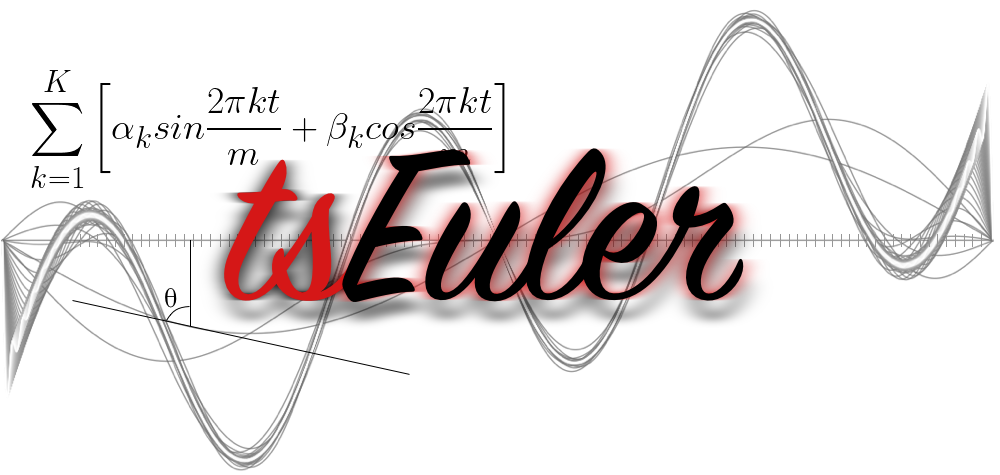

In [8]:
import tseuler as tsl
print(tsl.__version__)
tboard = tsl.TseulerBoard(tsdata=sundata,
                           data_desc=dataobj.long_description, 
                           target_columns=['MMTS'], dt_freq='M',
                           freq_conv_agg = 'mean', force_interactive=True)
tboard.get_board()

In [9]:
import pandas as pd
stocks_data = pd.read_csv('../Raw Data/stocks_data.csv', index_col=0, parse_dates=True)
print('Shape of the Stocks Data :', stocks_data.shape)
print('Number of Unique Tickers in the dataset : ', stocks_data.Name.nunique())
stocks_data.head()

Shape of the Stocks Data : (641233, 6)
Number of Unique Tickers in the dataset :  505


,open,high,low,close,volume,Name
2013-02-08,45.07,45.35,45.00,45.08,1824755.0,A
2013-02-11,45.17,45.18,44.45,44.60,2915405.0,A
2013-02-12,44.81,44.95,44.50,44.62,2373731.0,A
2013-02-13,44.81,45.24,44.68,44.75,2052338.0,A
2013-02-14,44.72,44.78,44.36,44.58,3826245.0,A


Column(background='white', height=1220)
    [0] Row(margin=(5, 5, 5, 5))
        [0] Column
            [0] PNG(str, width=300)
            [1] HTML(str)
        [1] Column
            [0] HTML(str)
            [1] Divider()
            [2] Row
                [0] Bokeh(Figure)
                [1] HTML(str, margin=(100, 5, 5, -30))
        [2] Column
            [0] HTML(str)
            [1] Divider()
            [2] Row
                [0] Bokeh(Figure)
                [1] HTML(str, margin=(100, 5, 5, -30))
    [1] Divider()
    [2] Row(margin=(-20, 5, -20, 5))
        [0] Column
            [0] Markdown(str)
            [1] HTML(str, margin=(5, 5, 5, 5))
        [1] Select(name='Name', options=['A', 'AAL', 'AAP', ...], value='A', width=80)
    [3] Divider()
    [4] Column(margin=(5, 5, -20, 5))
        [0] Row
            [0] Column
                [0] Markdown(str)
                [1] RadioButtonGroup(button_type='success', name='Analysis variant', options=OrderedDict([('UV', ...]), value='UV', width=660)
                [2] Row
                    [0] Markdown(str)
                    [1] Select(disabled=True, margin=(-5, 5, 5, 15), name='Y Select', options=OrderedDict([('close', ...]), value='close', width=180)
                    [2] IntInput(disabled=True, end=12, margin=(-5, 5, 5, 5), name='Y Lags', start=0, value_throttled=0, width=80)
                    [3] RadioButtonGroup(button_type='primary', disabled=True, margin=(12, 5, 5, 5), name='Y Transformation', options=OrderedDict([('Actual', ...]), value='Actual', width=330)
                [3] Row
                    [0] Markdown(str)
                    [1] Select(margin=(-5, 5, 5, 5), name='X1 Select', options=OrderedDict([('open', ...]), value='open', width=180)
                    [2] IntInput(end=12, margin=(-5, 5, 5, 5), name='X1 Lags', start=0, value_throttled=0, width=80)
                    [3] RadioButtonGroup(button_type='primary', margin=(12, 5, 5, 5), name='X1 Transformation', options=OrderedDict([('Actual', ...]), value='Actual', width=330)
                [4] Row
                    [0] Markdown(str)
                    [1] Select(disabled=True, margin=(-5, 5, 5, 5), name='X2 Select', options=OrderedDict([('open', ...]), value='open', width=180)
                    [2] IntInput(disabled=True, end=12, margin=(-5, 5, 5, 5), name='X2 Lags', start=0, value_throttled=0, width=80)
                    [3] RadioButtonGroup(button_type='primary', disabled=True, margin=(12, 5, 5, 5), name='X2 Transformation', options=OrderedDict([('Actual', ...]), value='Actual', width=330)
                [5] Markdown(str, width=660)
            [1] Column(width=300)
                [0] Markdown(str)
                [1] Select(margin=(-14, 5, 5, 5), name='Plot variant', options=OrderedDict([('Line Plot :...]), value='Line Plot : O..., width=290)
                [2] HTML(str)
                [3] ParamMethod(method)
        [1] Row(margin=(-490, 5, 5, 5))
            [0] ParamMethod(method)
            [1] HTML(str, margin=(-5, 5, 5, -300))
            [2] Select(margin=(-5, 5, 5, -100), name='Freq variant', options=OrderedDict([('Weeks', ...]), value='Weeks', width=100)
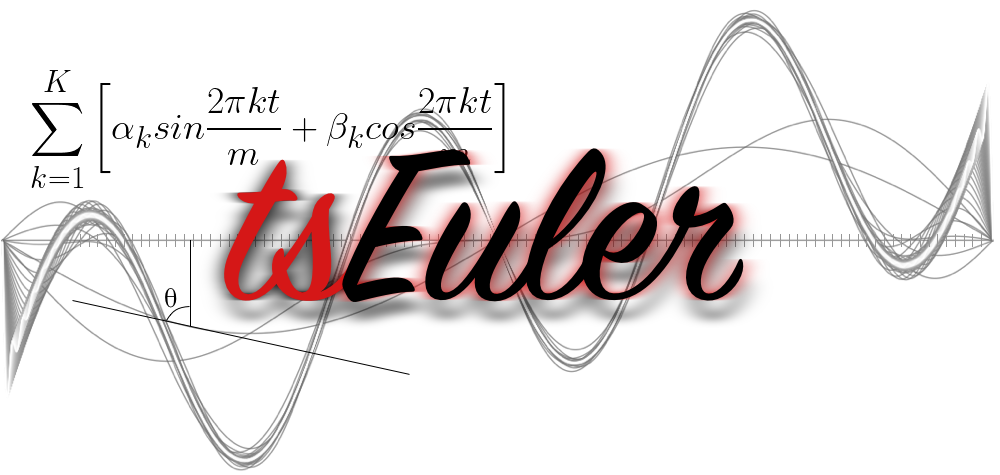

In [10]:
import tseuler as tsl
tboard = tsl.TseulerBoard(tsdata=stocks_data,
                          data_desc='Stocks Data', 
                          target_columns=['close'],
                          categorical_columns=['Name'],
                          dt_freq='B', freq_conv_agg = 'mean', force_interactive=True)
tboard.get_board()

# Random Testing Space

In [ ]:
from helperhandler import dataHolder
dataHolder.load_data()

In [ ]:
dataobj = dataHolder.bucket['retail_sales']
retail_data = dataobj.data.copy()

In [ ]:
import tseuler as tsl
tboard = tsl.TseulerBoard(tsdata=retail_data,
                          data_desc=dataobj.short_description, 
                          target_columns=['Weekly_Sales'],
                          categorical_columns=['Store'],
                          dt_freq='W', freq_conv_agg = 'mean', force_interactive=True)
tboard.get_board()